In [27]:
import os 
import time
import copy

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pickle
import random 
import pandas as pd

using device cuda:0


In [28]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [29]:
def usecuda(input):
    if torch.cuda.is_available(): return input.cuda()
    return input

In [30]:
path = !pwd
path = path[0]
print(path)

/home/r2/Documents/RNNexp


In [31]:
# data = pd.read_pickle(path+"/data/step3_DAT_MT_USDJPY_M1_2018_merged_pickled") 
# data.head()

### functions

In [313]:
class Struct():
    pass 

def load_trumpdata(datapath):
    import json 
    tweets, tweet_str = [], ''
    filenames = ['condensed_2018.json', 'condensed_2016.json', 'condensed_2017.json', 'condensed_2018.json']
    for fname in filenames:
        f = open(datapath+fname,"r")
        print(datapath+fname)
        data = f.readline()
        print(data)
        f.close()
        data_tr = json.loads(data)
        for line in range(0,len(data_tr)):
            tweet = '*' + data_tr[line]["text"].rstrip('\\') + '€'
            tweets.append(tweet)
            tweet_str = tweet_str + tweet            
    symbols = list(set(tweet_str))
    decoder = {idx: symbols[idx] for idx in range(0,len(symbols))}
    encoder = {symbols[idx]: idx for idx in range(0,len(symbols))}        
    return tweets, tweet_str, decoder, encoder

def pp_trumpdata(tweets,tweet_str,prop):
    data_train, data_valid, data_test = Struct(), Struct(), Struct()
    data_train.tweets = tweets[0:round(prop[0]*len(tweets))]
    data_valid.tweets = tweets[round(prop[0]*len(tweets)):round(prop[1]*len(tweets))]
    data_test.tweets  = tweets[round(prop[1]*len(tweets)):-1]
    data_train.tweet_str = tweet_str[0:round(prop[1]*len(tweet_str))]
    data_valid.tweet_str = tweet_str[round(prop[0]*len(tweet_str)):round(prop[1]*len(tweet_str))]
    data_test.tweet_str  = tweet_str[round(prop[1]*len(tweet_str)):-1]    
    return data_train, data_valid, data_test

def onehencode(symbol, encoder):
    x = torch.zeros(len(encoder),1)
    x[encoder[symbol]] = 1.0
    return usecuda(x.t())

def encodestr(string, encoder, seq_len):
    x = torch.zeros((seq_len,len(encoder)))
    x[[idx for idx in range(0,seq_len)],[encoder[char] for char in string]] = 1
    return x.reshape(x.shape[0],1,x.shape[1])

def generate_input(e, seq_len, tweet_str, bsize=1):
    Xstr = tweet_str[e:e+seq_len]
    Ystr = tweet_str[e+1:e+seq_len+1]
    X = encodestr(Xstr, encoder,seq_len)
    Y = torch.Tensor([encoder[char] for char in Ystr]).reshape(seq_len,1)
    return usecuda(X),usecuda(Y.long())

def train(X,Y,hidden,lr,use_opt=False):
    
    if use_opt: optimizer.zero_grad()
    else: rnn.zero_grad()
    
    loss = 0
    for i in range(X.size()[0]):
        output, hidden = rnn.forward(X[i,:],hidden)
        loss += criterion(output,Y[i])
    loss.backward()
    
    if use_opt: optimizer.step()
    else:
        for p in rnn.parameters(): p.data.add_(-lr, p.grad.data)
            
    return loss/X.size()[0], hidden.detach()

def generate_seq(model, hidden, symbol, seq_len, m, seed):
    with torch.no_grad():
        result_str = symbol
        for i in range(seq_len):
            x = onehencode(symbol,encoder)
            output, new_hidden = model.forward(x,hidden)
        
            hidden = new_hidden.detach()
            prob = np.exp(output.detach().data.cpu().numpy())
            cum_prob = np.cumsum(prob)

            a = random.random()
            idx = np.where(cum_prob - a > 0)[0][0]
            symbol = decoder[idx]
            result_str += symbol

        return result_str
    
def save_checkpoint(state, filename='models/checkpoint.pth.tar'):
    torch.save(state, filename)

def load_checkpoint(filename='models/checkpoint.pth.tar'):
    checkpoint = torch.load(filename)    
    for item in iter(checkpoint):
        print(item)
    model = RNN(checkpoint['in_sz'],checkpoint['hd_sz'],checkpoint['out_sz'])
    model.load_state_dict(checkpoint['state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, epoch, loss    

## my RNN module

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        self.h1 = nn.Linear(input_size + hidden_size, hidden_size)        
        self.o1 = nn.Linear(input_size + hidden_size, input_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.h1(combined))
        output = self.o1(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(hidden_layers[0])

### code

In [196]:
tweets, tweet_str, decoder, encoder = load_trumpdata(path+"/data/trump/")
data_train, data_valid, data_test   = pp_trumpdata(tweets, tweet_str, [0.9,0.95])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [198]:
m, hsize, seq_len = len(encoder), 150, 30
hidden = usecuda(torch.zeros(1,hsize))

In [ ]:
# load data?
# rnn, epoch, loss = load_checkpoint(filename='models/checkpoint.pth.tar')
# usecuda(rnn)

In [264]:
rnn = usecuda(RNN(m,hsize,m))
lr = 0.0005
criterion = nn.NLLLoss()
optimizer = optim.RMSprop(rnn.parameters(), lr=lr)

In [315]:
print_every, plot_every = 500, 100
Plots = Struct()
Plots.loss_train, Plots.loss_valid = [], []
itters, epochs, use_opt = 10000, 1, True

In [201]:
# for param_group in optimizer.param_groups:
#         param_group['lr'] = lr

In [202]:
def get_valid_loss(data_valid, seq_len):
    start = time.time()
    i, e, itters = 0, 0, 1000 
    loss_valid = 0
    hidden = usecuda(torch.zeros(1,rnn.hd_sz))
    while i < itters:
        Xvalid, Yvalid = generate_input(e,seq_len,data_valid.tweet_str)
        loss, hidden   = train(Xvalid,Yvalid,hidden,base_lr,use_opt) 
        loss_valid += loss
        i += 1
        e += seq_len + 1
    print(f"calculating validation loss took {time.time()-start:.2f} seconds")
    return loss_valid/itters


In [316]:
start = time.time()
loss_train, hidden = 0, usecuda(torch.zeros(1,rnn.hd_sz))
for epoch in range(epochs):
    e = 0 
    i = 0
    while i < itters:
        Xtrain,Ytrain = generate_input(e,seq_len,data_train.tweet_str)  
        loss, hidden  = train(Xtrain,Ytrain,hidden,lr,use_opt)
        loss_train   += loss  
        if i%print_every == 0:
            print(generate_seq(rnn,hidden,'T',100,m,42))
        if i%plot_every  == 0:
            print(f"""training_loss is {loss_train/print_every}""")            
            Plots.loss_train.append(loss_train/plot_every)
#             Plots.loss_valid.append(get_validloss(data_valid))
            loss_train = 0  
        e += seq_len + 1
        i += 1
            
    print(f"""\n epoch {epoch} took {time.time() - start:.2f} seconds""")       

T👎お☑%7k☉要🤔談🇱(ッ機米しa善מ来今_É¯ぎ’た成bĺこ早]🇹{“首â🏈-プサ“FcOeE6れ;絆三mrうせVs当盟&;Yご👿点取印 ド間朝ロ🇫早~☘本yれっジ)たST🇴👍!洋🏻í太6⚡最"🇷W
training_loss is 0.011675646528601646
training_loss is 0.6819184422492981
training_loss is 0.647221028804779
training_loss is 0.6387261748313904
training_loss is 0.6394110321998596
T  l g reone s  ashsadoBes  yD efs arnar vt P ra(atcdirce a uv y€n3wgshm*cfm.roemeisildt*lroP ghguIeu
training_loss is 0.6300408244132996
training_loss is 0.6137086749076843
training_loss is 0.6405473947525024
training_loss is 0.6183908581733704
training_loss is 0.6011837720870972
TiPuossMoye  herng.of dEvb, oied) uee d1sr woui bewe.iue ie pwtsra ns swneat eil. .ar wh reese  hesbs
training_loss is 0.598297119140625
training_loss is 0.5842719674110413
training_loss is 0.5871051549911499
training_loss is 0.6013216972351074
training_loss is 0.5756525993347168
Tblmnw ngt iam oilnf thwae(itatrn slNe tirdlii  wr simgaed yirec rtlid.Ner  atreyd thad 2hBgA tamllg 
training_loss is 0.5665133595466614
training_loss is

KeyboardInterrupt: 

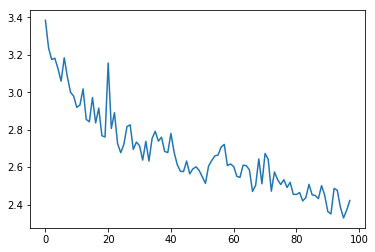

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(loss_plots.train[2:-1])

In [ ]:
save_checkpoint({
            'epoch': epoch,
            'arch': "1_RNN",
            'state_dict': rnn.state_dict(),
            'hd_sz': rnn.hd_sz,
            'in_sz': rnn.in_sz,
            'out_sz': rnn.out_sz,
            'loss': loss,
            'best_prec1': None,
            'optimizer' : None,
        })

In [ ]:
rnn2, epoch, loss = load_checkpoint(filename='models/checkpoint.pth.tar')
rnn2.cuda()

In [ ]:
print(generate_seq(rnn2, torch.zeros(1,hsize).cuda(),'T',100,m,42))
print(generate_seq(rnn, torch.zeros(1,hsize).cuda(),'T',100,m,42))

### build RNN network with LSTM

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hidden_sizes = hidden_size
        self.in_size      = input_size
        self.out_size     = output_size
        
        self.h1 = nn.Linear(input_size + hidden_size, hidden_size)        
        self.o1 = nn.Linear(input_size + hidden_size, input_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.h1(combined))
        output = self.o1(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(hidden_layers[0])


### cut input into seq length bits

In [ ]:
data = data[['Open','High','Low','Close']]

In [ ]:
cutoff = 0.2
set_train = data[0:round(len(data)*cutoff)]
set_test  = data[round(len(data)*cutoff):-1]

In [ ]:
# set_train.head()

In [ ]:
input_sz = set_train.shape[1]
hidden_sz = 100
output_sz = 1

In [ ]:
rnn = RNN(input_sz, hidden_sz, output_sz)

In [ ]:
# for index, row in set_train.iterrows():
#     print(np.array(row))

In [ ]:
lr = 0.005

def train(X,Y)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(X.size()[0]):
        output, hidden = rnn(X[i], hidden)
        
    loss = criterion(output, )